# Intermediate Tutorial: Choosing the Right Optimizer

This tutorial explores different optimization methods and when to use them. We'll work with increasingly complex objective function surfaces to understand why different algorithms are needed.

## Learning Objectives

By the end of this tutorial, you will:

- Understand when to use different optimization methods
- See how complex objective surfaces affect optimization
- Learn about global vs local optimizers
- Compare results from different methods


## 1. Setup


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from ezfit.examples import (
    generate_gaussian_data,
    generate_linear_data,
)

plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (12, 8)

## 2. Simple Case: Linear Fitting

For simple, well-behaved functions, the default `curve_fit` method works perfectly:


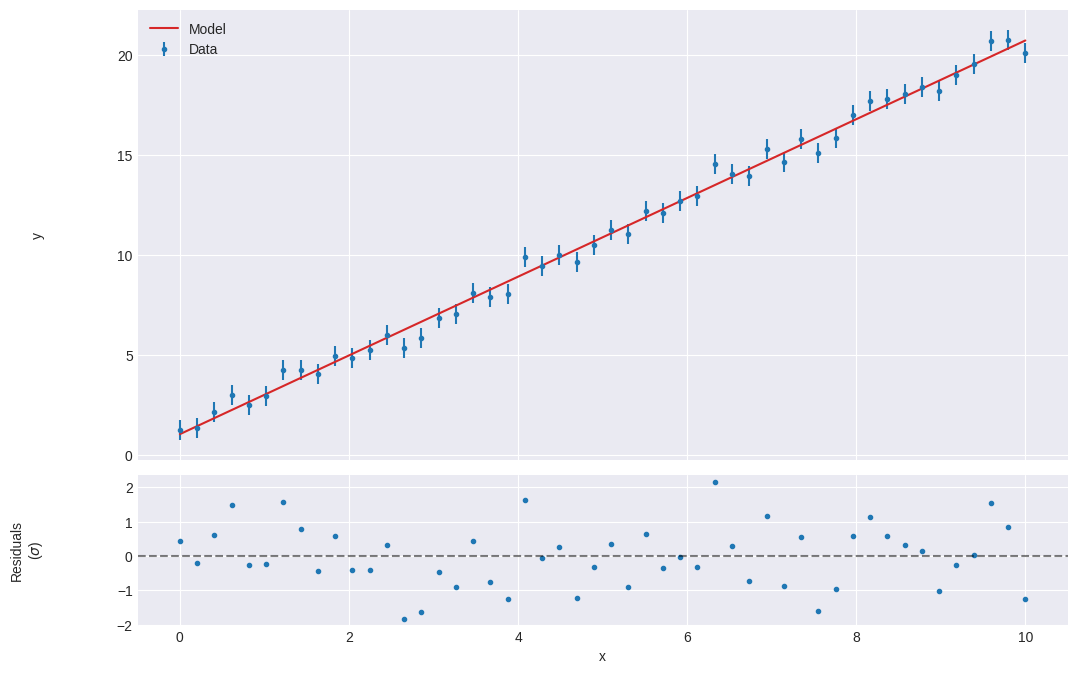

Default method (curve_fit):
  m = 1.9710 ± 0.0240
  b = 1.0322 ± 0.1393
  χ² = 41.26


In [2]:
# Generate simple linear data
df_linear = generate_linear_data(n_points=50, slope=2.0, intercept=1.0, seed=42)


def line(x, m, b):
    return m * x + b


# Default method: curve_fit (Levenberg-Marquardt)
model1, ax1, _ = df_linear.fit(line, "x", "y", "yerr", method="curve_fit")
plt.show()
print("Default method (curve_fit):")
print(f"  m = {model1['m'].value:.4f} ± {model1['m'].err:.4f}")
print(f"  b = {model1['b'].value:.4f} ± {model1['b'].err:.4f}")
print(f"  χ² = {model1.𝜒2:.2f}")

## 3. When Initial Guesses Matter: Gaussian Peak

For functions with multiple parameters or local minima, initial guesses become important. Let's fit a Gaussian peak:


=== Poor Initial Guess ===


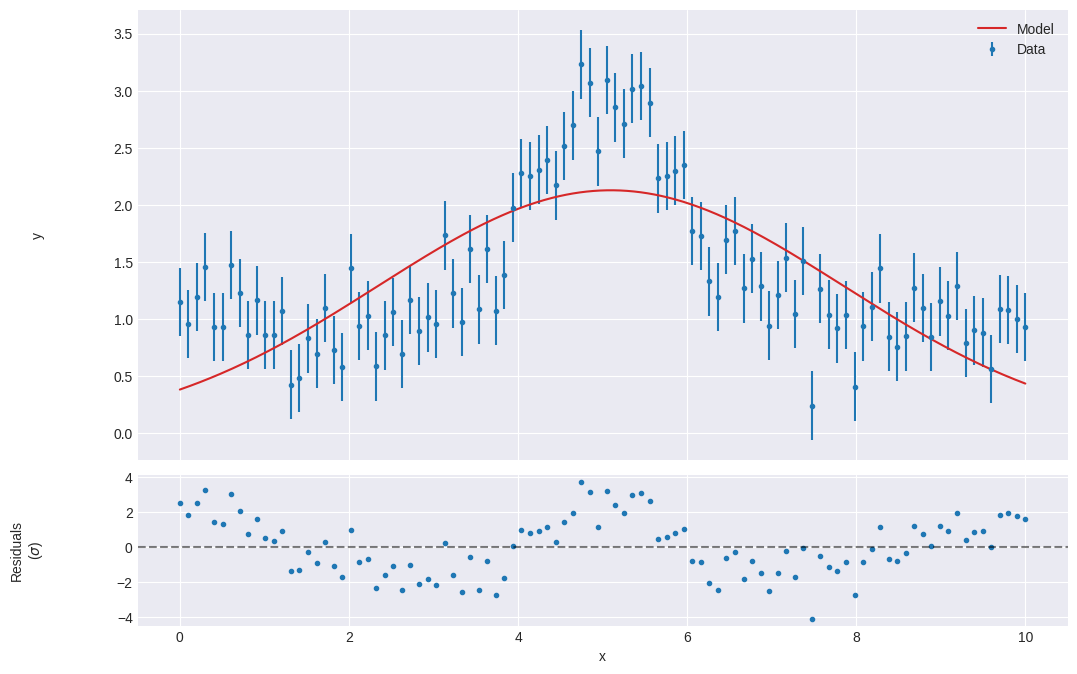

gaussian
amplitude : (value = 2.13 ± 0.055, bounds = (-inf, inf))
center : (value = 5.1 ± 0.082, bounds = (-inf, inf))
fwhm : (value = -6.5 ± 0.22, bounds = (-inf, inf))
𝜒2: 281.26055607179745
reduced 𝜒2: 2.8995933615649223
covariance:
[[ 0.003  -0.      0.0074]
 [-0.      0.0068 -0.0003]
 [ 0.0074 -0.0003  0.0486]]
correlation:
[[ 1.     -0.0081  0.6121]
 [-0.0081  1.     -0.0181]
 [ 0.6121 -0.0181  1.    ]]

=== Good Initial Guess ===


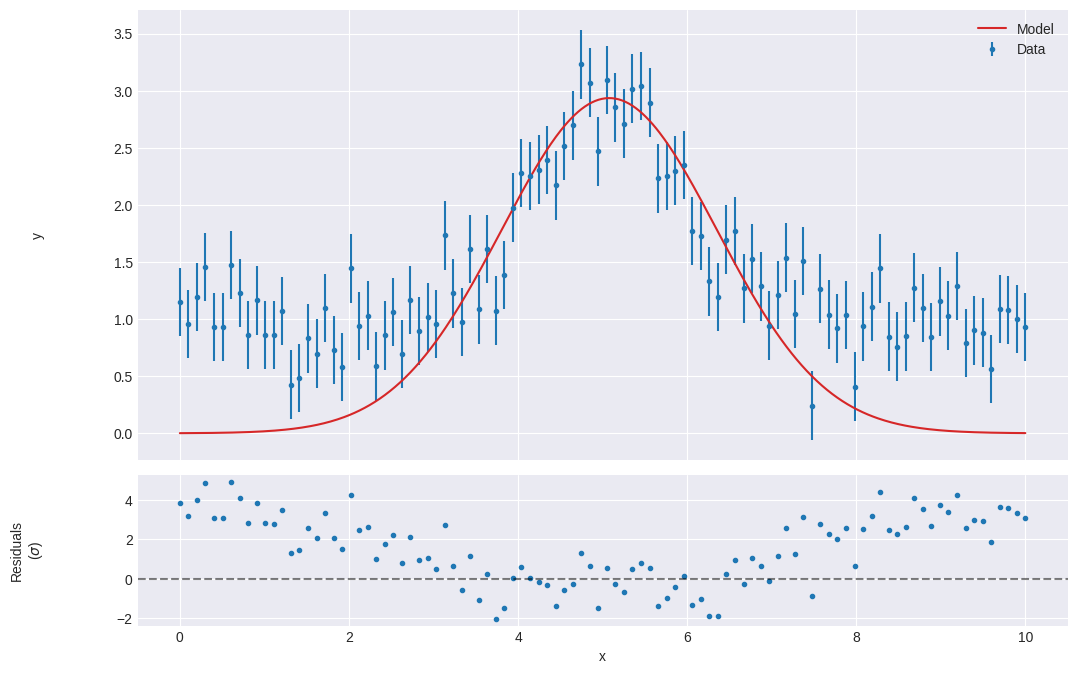

gaussian
amplitude : (value = 2.94 ± 0.078, bounds = (1, 3))
center : (value = 5.08 ± 0.039, bounds = (4, 6))
fwhm : (value = 3.0 ± 0.092, bounds = (1, 3))
𝜒2: 547.7744669923793
reduced 𝜒2: 5.647159453529683
covariance:
[[ 0.006  -0.     -0.0041]
 [-0.      0.0015  0.    ]
 [-0.0041  0.      0.0084]]
correlation:
[[ 1.     -0.     -0.5774]
 [-0.      1.      0.    ]
 [-0.5774  0.      1.    ]]


In [3]:
# Generate Gaussian peak data
df_gauss = generate_gaussian_data(
    n_points=100, amplitude=2.0, center=5.0, fwhm=2.0, seed=42
)

# Use built-in Gaussian function
from ezfit import gaussian

# Try with poor initial guess
print("=== Poor Initial Guess ===")
model_bad, ax_bad, _ = df_gauss.fit(
    gaussian,
    "x",
    "y",
    "yerr",
    amplitude={"value": 5.0},  # Too high
    center={"value": 1.0},  # Wrong position
    fwhm={"value": 5.0},  # Too narrow
)
plt.show()
print(model_bad)

# Try with good initial guess
print("\n=== Good Initial Guess ===")
model_good, ax_good, _ = df_gauss.fit(
    gaussian,
    "x",
    "y",
    "yerr",
    amplitude={"value": 2.0, "min": 1, "max": 3},  # Close to true value
    center={"value": 5.0, "min": 4, "max": 6},  # Close to true value
    fwhm={"value": 2.0, "min": 1, "max": 3},  # Close to true value
)
plt.show()
print(model_good)

## 4. Global Optimization: Rugged Surface

When the objective function has multiple local minima, local optimizers can get stuck. This is when you need global optimizers like `differential_evolution`:


=== Local Optimizer (minimize) ===


/home/hduva/projects/ezfit/.venv/lib/python3.12/site-packages/ezfit/fit.py:232: UserWarning: Zero standard deviation found in covariance matrix diagonal,cannot compute correlation matrix.
  fit_result = _fit_curve_fit(


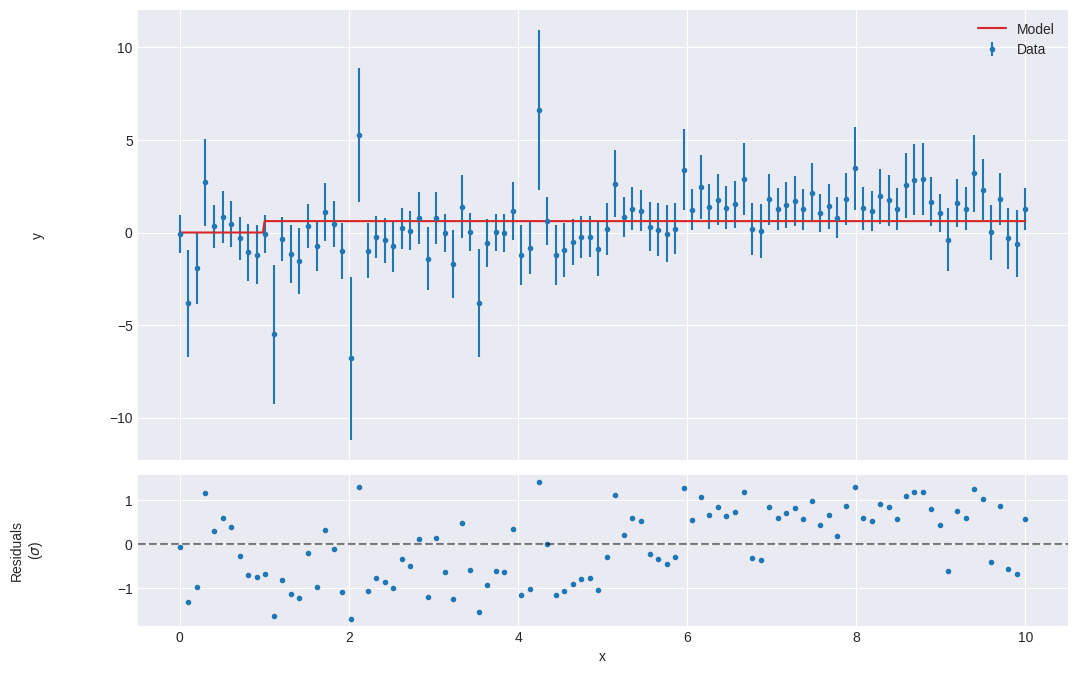

χ² = 69.09

=== Global Optimizer (differential_evolution) ===


/home/hduva/projects/ezfit/.venv/lib/python3.12/site-packages/ezfit/fit.py:254: UserWarning: Could not invert Hessian to compute covariance matrix. Uncertainties not available.
  fit_result = _fit_differential_evolution(


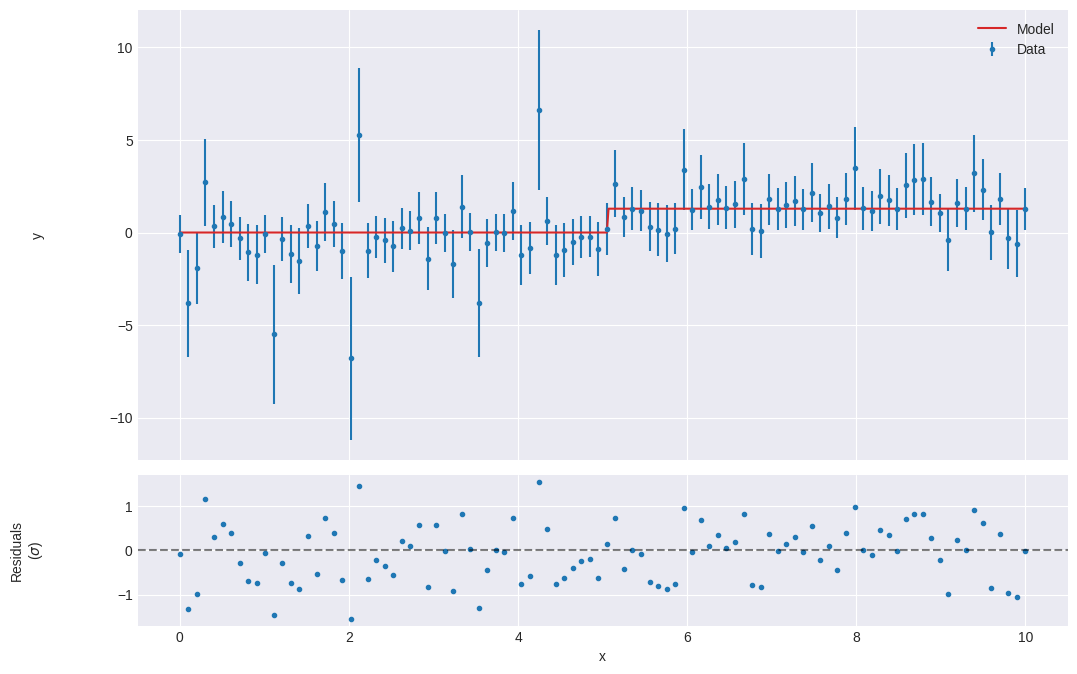

χ² = 42.73

Global optimizer finds better fit!


In [4]:
# Generate data with complex, multi-modal surface
from ezfit.examples import generate_rugged_step_edge_data

df_rugged = generate_rugged_step_edge_data(
    c=5, H=1, x_range=(0, 10), n_points=100, noise_level=1
)


# Define a model that approximates the complex function using 4 peaks and a linear background
def step_edge(x: np.ndarray, c: float, H: float) -> np.ndarray:
    return H * (x > c)


truth = {
    "c": 5.0,
    "H": 1.0,
}

domain = {
    "c": {"value": 1.0, "min": 0, "max": 10},
    "H": {"value": 1.0, "min": 0, "max": 10},
}

# Try with local optimizer (may get stuck in local minimum)
print("=== Local Optimizer (minimize) ===")
try:
    model_local, ax_local, _ = df_rugged.fit(step_edge, "x", "y", "yerr", **domain)
    plt.show()
    print(f"χ² = {model_local.𝜒2:.2f}")
except Exception as e:
    print(f"Failed: {e}")

# Try with global optimizer
print("\n=== Global Optimizer (differential_evolution) ===")
model_global, ax_global, _ = df_rugged.fit(
    step_edge,
    "x",
    "y",
    "yerr",
    method="differential_evolution",
    fit_kwargs={"maxiter": 1000, "seed": 42},
    **domain,
)
plt.show()
print(f"χ² = {model_global.𝜒2:.2f}")
print("\nGlobal optimizer finds better fit!")

## 5. Comparing Different Methods

Let's compare multiple optimization methods on the same problem:


In [5]:
# Compare the standard rugged surface data set using multiple optimizers

# Use the standard (default) rugged surface data created previously
# (assumes df_rugged and two_gaussians are defined from above)

methods = ["curve_fit", "minimize", "differential_evolution"]
fit_kwargs = {
    "curve_fit": {},
    "minimize": {"method": "L-BFGS-B"},
    "differential_evolution": {
        "x0": [value["value"] for value in domain.values()],
        "seed": 42,
    },
}
results = {}

for method in methods:
    try:
        print(f"\n=== {method.upper()} ===")
        model, ax, _ = df_rugged.fit(
            step_edge,
            "x",
            "y",
            "yerr",
            method=method,
            fit_kwargs=fit_kwargs[method],
            **domain,
        )
        results[method] = {"model": model, "chi2": model.𝜒2}
        print(f"χ² = {model.𝜒2:.2f}")
        plt.close()  # Close plot to save memory
    except Exception as e:
        print(f"Failed: {e}")
        results[method] = None

# Compare results
print("\n" + "=" * 50)
print("COMPARISON SUMMARY")
print("=" * 50)
for method, result in results.items():
    if result:
        print(f"{method:25s}: χ² = {result['chi2']:.2f}")
    else:
        print(f"{method:25s}: Failed")


=== CURVE_FIT ===
χ² = 69.09

=== MINIMIZE ===
χ² = 69.09

=== DIFFERENTIAL_EVOLUTION ===
χ² = 42.73

COMPARISON SUMMARY
curve_fit                : χ² = 69.09
minimize                 : χ² = 69.09
differential_evolution   : χ² = 42.73


## 6. Visualizing the Best Fit

Let's plot the best result:


Best method: differential_evolution


/home/hduva/projects/ezfit/.venv/lib/python3.12/site-packages/ezfit/fit.py:254: UserWarning: Could not invert Hessian to compute covariance matrix. Uncertainties not available.
  fit_result = _fit_differential_evolution(


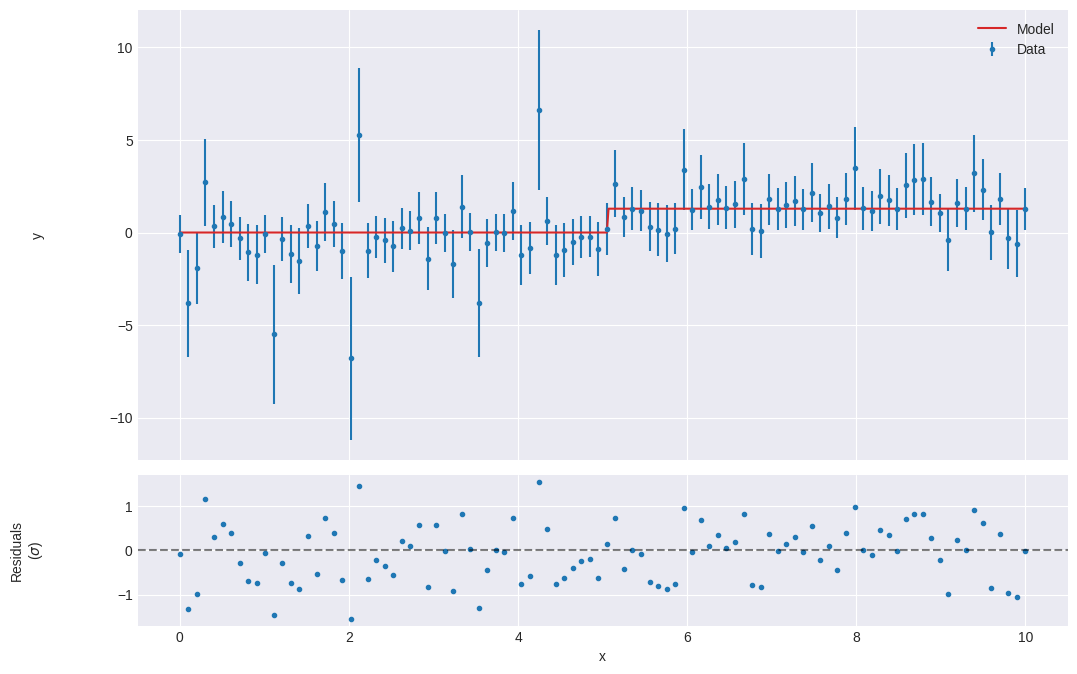

step_edge
c : (value = 5.06 ± N/A, bounds = (0, 10))
H : (value = 1.29 ± N/A, bounds = (0, 10))
𝜒2: 42.72991634078647
reduced 𝜒2: 0.4360195544978211
covariance:
[[nan nan]
 [nan nan]]
correlation:
[[0. 0.]
 [0. 0.]]


In [7]:
# Find best method
best_method = min(
    [m for m, r in results.items() if r], key=lambda m: results[m]["chi2"]
)

print(f"Best method: {best_method}")

# Re-fit and plot
model_best, ax_best, ax_res_best = df_rugged.fit(
    step_edge,
    "x",
    "y",
    "yerr",
    method=best_method,
    fit_kwargs=fit_kwargs[best_method],
    **domain,
)

plt.show()
print(model_best)

## 7. When to Use Which Method?

### Decision Tree:

1. **Simple, well-behaved functions** → `curve_fit` (default)

   - Fast, reliable for most cases
   - Good initial guesses usually sufficient

2. **Many local minima or complex surfaces** → `differential_evolution` or `dual_annealing`

   - Global optimizers that search entire parameter space
   - Slower but more robust

3. **Need uncertainty estimates** → `curve_fit` or `emcee` (MCMC)

   - `curve_fit` provides covariance matrix
   - `emcee` provides full posterior distributions

4. **Linear models** → `ridge`, `lasso`, or `bayesian_ridge`
   - Specialized methods for linear regression
   - Can handle regularization

## Summary

In this tutorial, you learned:

1. ✅ When initial guesses matter
2. ✅ The difference between local and global optimizers
3. ✅ How to compare different methods
4. ✅ When to use each optimization method

**Next Steps:**

- Try the advanced tutorial to learn about MCMC and constraints
- Experiment with your own complex models
- Read about parameter constraints in the documentation
